In [11]:
import subprocess
import numpy as np
from pathlib import Path
import re
import json

from matplotlib import pyplot as plt
from rune_py import Fft, NoiseFiltering
import scipy.io.wavfile as wavfile

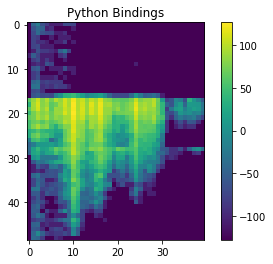

In [43]:
sample_rate,data = wavfile.read('84d1e469_nohash_0.wav')

fft = Fft()
fft.sample_rate = 16000

noise_filtering = NoiseFiltering()

noise_filtering.smoothing_bits = 10
noise_filtering.even_smoothing = 0.025
noise_filtering.odd_smoothing = 0.06
noise_filtering.min_signal_remaining = 0.05
noise_filtering.strength = 0.95
noise_filtering.offset = 80.0
noise_filtering.gain_bits = 21

# with rune spec
rune_spec = noise_filtering(fft(data))

plt.title("Python Bindings")
plt.imshow(np.reshape(rune_spec, [49, 40]))
plt.colorbar()
plt.show()

In [46]:
def rune_binary_spectrum(rune: Path, wav_file: Path) -> np.ndarray:
    args = ["cargo", "rune", "run", rune, "--capability", f"sound:{wav_file.name}"]
    output = subprocess.run(args, stderr=subprocess.PIPE)
    
    stderr = output.stderr.decode("UTF-8")

    assert output.returncode == 0, stderr
    
    for line in stderr.splitlines():
        if "Serial:" in line:
            start_of_json = line.index("{")
            message = json.loads(line[start_of_json:])
            return np.array(message["elements"]).reshape(*message["dimensions"])
        
def git_root_folder(cwd: Path) -> Path:
    args = ["git", "rev-parse", "--show-toplevel"]
    output = subprocess.run(args, cwd=cwd, stdout=subprocess.PIPE, check=True)
    path = Path(output.stdout.decode("UTF-8").strip())
    
    assert path.exists()
    return path

In [47]:
project_root = git_root_folder(Path("."))

repro_dir = project_root.joinpath("examples", "repro")
wav_file = repro_dir.joinpath("84d1e469_nohash_0.wav")
rune = repro_dir.joinpath("repro.rune")

if not rune.exists():
    subprocess.run(["cargo", "rune", "build", repro_dir.joinpath("Runefile")], check=True)

assert wav_file.exists()

spectrum = rune_binary_spectrum(rune, wav_file).reshape(49, 40)

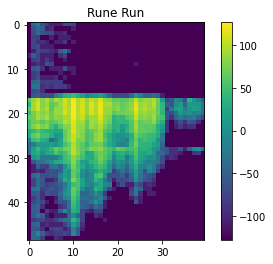

In [48]:
plt.title("Rune Run")
plt.imshow(spectrum)
plt.colorbar()
plt.show()